<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/main/13-GANs/GAN_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (15 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (30 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (20 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Простой конфиг (для хранения параметров, можете использовать и модифицировать)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 500

### Создаем dataloader

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)
len(dataloader)

3750

In [5]:
image, label = next(iter(dataloader))
image.size()

torch.Size([16, 1, 28, 28])

### Создаем модель GAN

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [7]:
generator = Generator()
discriminator = Discriminator()

### Оптимизатор и функция потерь

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = generator.to(device)
discriminator = discriminator.to(device)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Для оптимизации процесса обучения можно заранее определить переменные и заполнять их значения новыми данными

In [9]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device))
# fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size, device=device))
real_label = 1
fake_label = 0

### GAN обучение

In [10]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        output = discriminator(input_data).view(-1)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 500 errD_x: 0.14 errD_z: 0.07 errG: 2.67
Epoch:1 Iter: 1000 errD_x: 0.01 errD_z: 0.13 errG: 2.41
Epoch:1 Iter: 1500 errD_x: 0.20 errD_z: 0.14 errG: 2.56
Epoch:1 Iter: 2000 errD_x: 0.11 errD_z: 0.18 errG: 2.15
Epoch:1 Iter: 2500 errD_x: 0.64 errD_z: 0.13 errG: 2.73
Epoch:1 Iter: 3000 errD_x: 0.08 errD_z: 0.12 errG: 3.22
Epoch:1 Iter: 3500 errD_x: 0.36 errD_z: 0.06 errG: 3.76
Epoch:2 Iter: 500 errD_x: 0.15 errD_z: 0.06 errG: 3.47
Epoch:2 Iter: 1000 errD_x: 0.15 errD_z: 0.03 errG: 4.22
Epoch:2 Iter: 1500 errD_x: 0.07 errD_z: 0.07 errG: 3.49
Epoch:2 Iter: 2000 errD_x: 0.04 errD_z: 0.08 errG: 3.64
Epoch:2 Iter: 2500 errD_x: 0.30 errD_z: 0.27 errG: 2.78
Epoch:2 Iter: 3000 errD_x: 0.32 errD_z: 0.02 errG: 4.31
Epoch:2 Iter: 3500 errD_x: 0.02 errD_z: 0.13 errG: 3.34
Epoch:3 Iter: 500 errD_x: 0.07 errD_z: 0.22 errG: 2.53
Epoch:3 Iter: 1000 errD_x: 0.17 errD_z: 0.08 errG: 3.10
Epoch:3 Iter: 1500 errD_x: 0.07 errD_z: 0.07 errG: 2.96
Epoch:3 Iter: 2000 errD_x: 0.10 errD_z: 0.17 errG: 

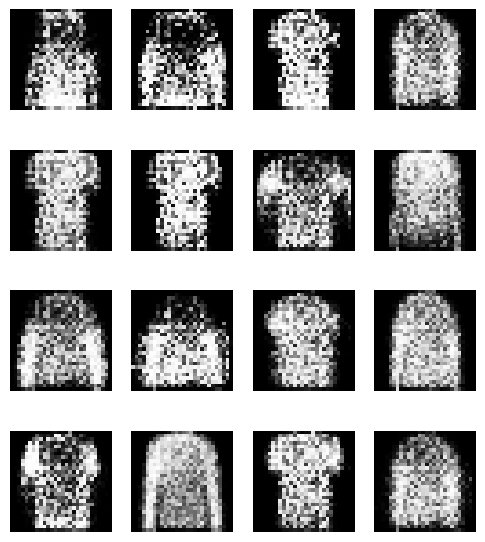

In [11]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')